# Imports

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# Input de DataSet

In [14]:
datasets = [pd.read_csv(f'datasets/urbansounds_features_{i}.csv') for i in range(1, 11)]

# Clean the DataSet

In [15]:
for df in datasets:
    object_columns = df.select_dtypes(include=['object']).columns
    print(object_columns)

Index(['fourier_tempogram', 'Label'], dtype='object')
Index(['fourier_tempogram', 'Label'], dtype='object')
Index(['fourier_tempogram', 'Label'], dtype='object')
Index(['fourier_tempogram', 'Label'], dtype='object')
Index(['fourier_tempogram', 'Label'], dtype='object')
Index(['fourier_tempogram', 'Label'], dtype='object')
Index(['fourier_tempogram', 'Label'], dtype='object')
Index(['fourier_tempogram', 'Label'], dtype='object')
Index(['fourier_tempogram', 'Label'], dtype='object')
Index(['fourier_tempogram', 'Label'], dtype='object')


In [16]:
def calculate_mean_from_string(string):
    cleaned_string = string.replace('\n', '')
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", cleaned_string)
    array = np.array(numbers, dtype=float)
    mean_value = np.mean(array)
    return mean_value

In [18]:
for df in datasets:
    column_intervals = df.describe().loc[['min', 'max']]
    print(column_intervals)

     chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms  \
min     0.009734    0.150077     0.126660       0.017318  0.001788   
max     0.829676    0.768014     0.285653      30.430030  0.473862   

         centroid    bandwidth   contrast      flatness       rolloff  ...  \
min     50.916749    71.255507   5.698971  6.211397e-07    106.979450  ...   
max  10907.707763  7088.299210  24.957858  9.798845e-01  18628.717306  ...   

      mcffs_31   mcffs_32   mcffs_33   mcffs_34   mcffs_35  mcffs_36  \
min -13.133705 -11.730761 -13.273888 -15.653493  -9.955764 -6.521128   
max  10.714517  11.225185   9.078557  15.806270  17.319443  9.707691   

      mcffs_37   mcffs_38  mcffs_39   mcffs_40  
min -21.866919 -19.719917 -8.652861  -6.523879  
max  17.943160   7.872053  7.306795  16.392504  

[2 rows x 52 columns]
     chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms  \
min     0.008760    0.191508     0.136980       0.056502  0.004293   
max     0.841217    0.77037

In [9]:
for df in datasets:
    for column in df.columns:
        if column != 'Label':
            if df[column].dtype != float and df[column].dtype != int:
                df[column] = df[column].apply(calculate_mean_from_string)
            df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
        else:
            df[column] = df[column].str.split('-').str[1].astype(int)

Fold 1


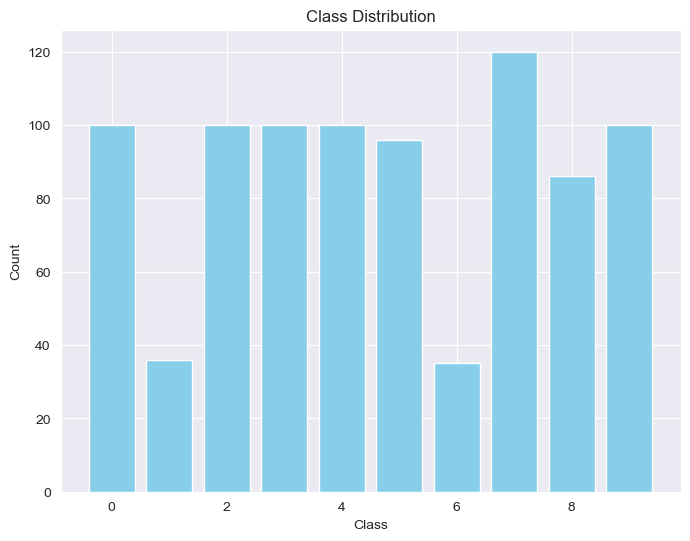

Fold 2


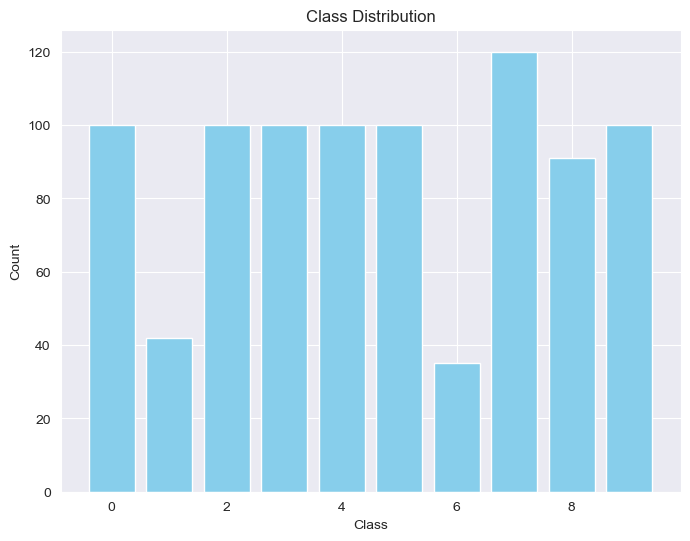

Fold 3


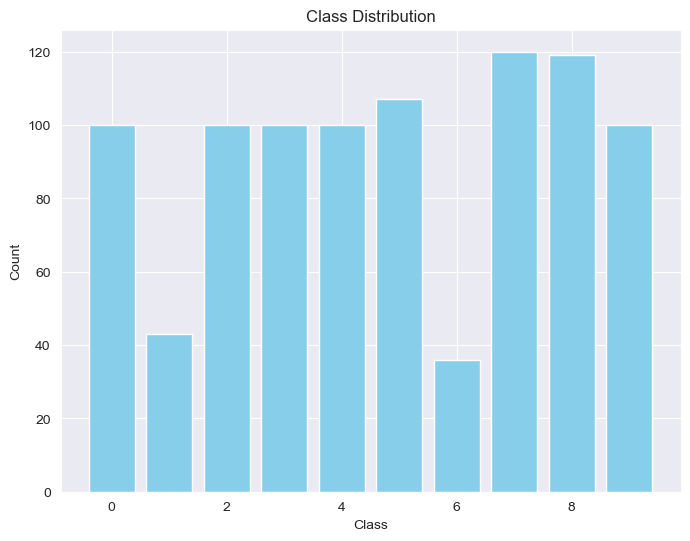

Fold 4


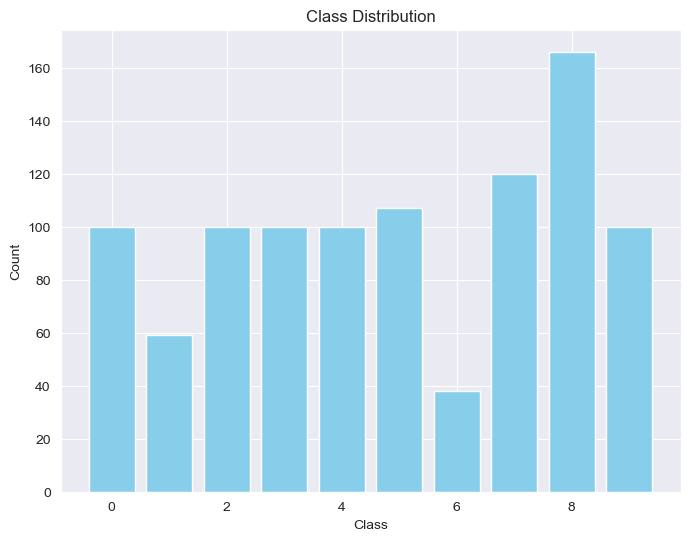

Fold 5


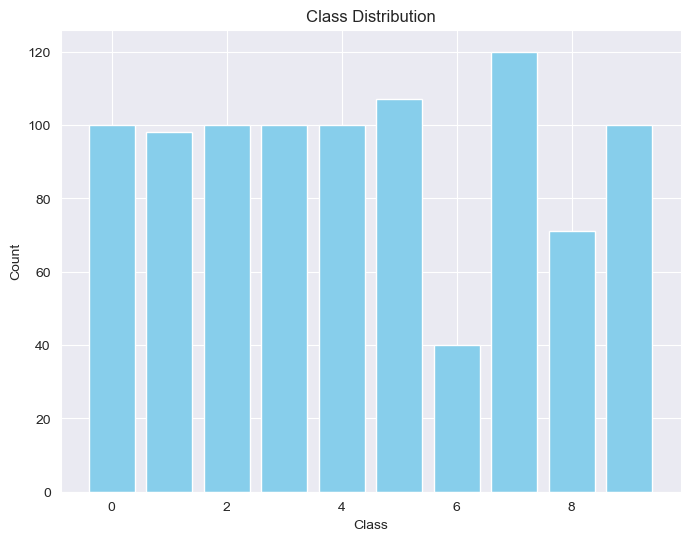

Fold 6


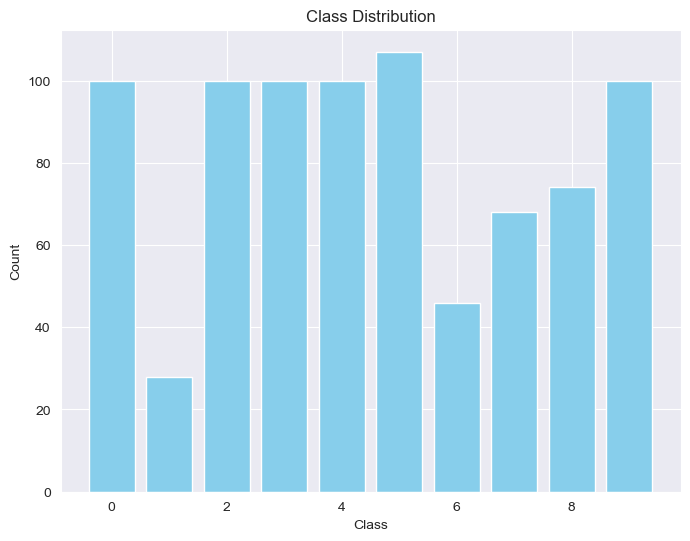

Fold 7


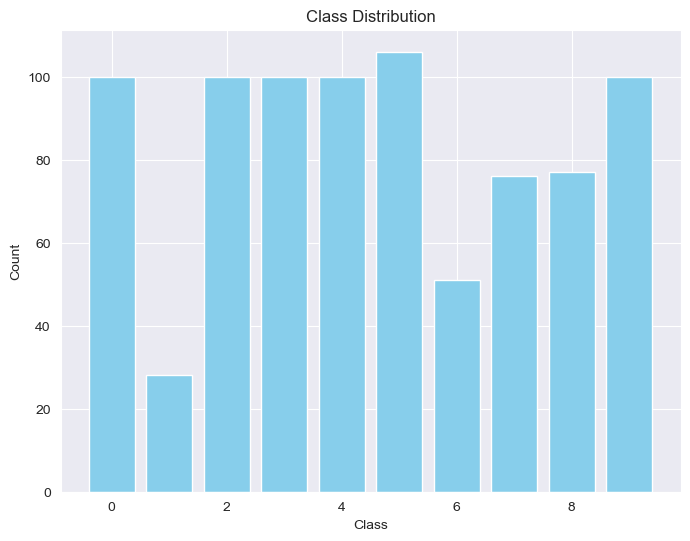

Fold 8


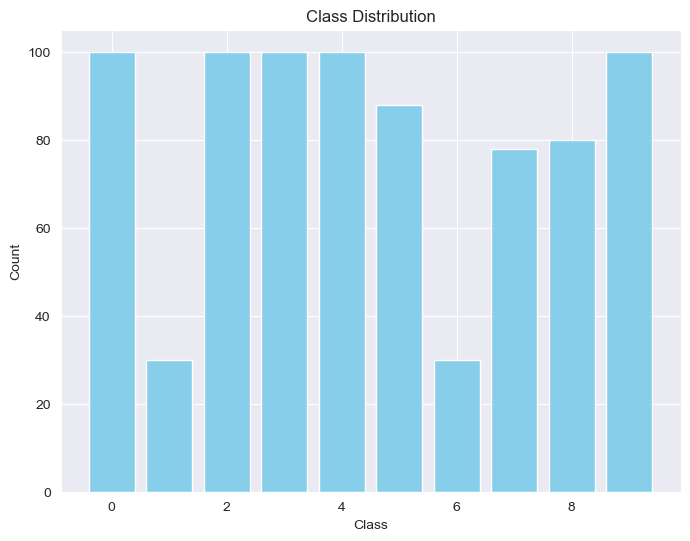

Fold 9


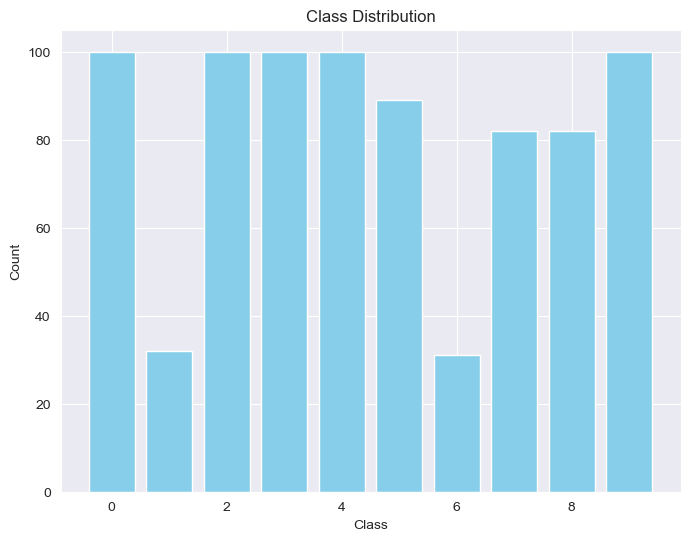

Fold 10


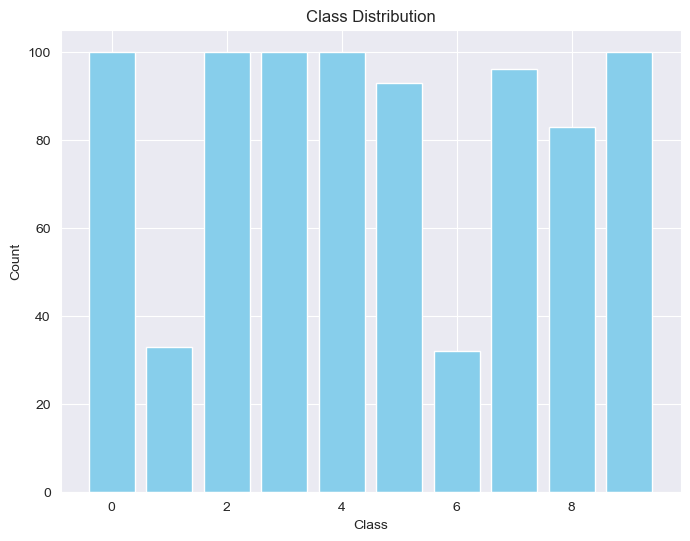

In [11]:
fold = 0
for df in datasets:
    print(f"Fold {fold + 1}")
    fold += 1
    class_counts = df['Label'].value_counts()
    class_labels = class_counts.index
    class_values = class_counts.values
    
    plt.figure(figsize=(8, 6))
    plt.bar(class_labels, class_values, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()

# Classification

In [5]:
def plot_learning_curve(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [6]:
def plot_confusion_matrix(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [7]:
def prepare_datasets(fold):
    test_data = datasets[fold]
    test_labels = test_data['Label'].values
    test_data = test_data.drop(columns=['Label']).values

    train_datasets = datasets[:fold] + datasets[fold + 1:]

    train_data = pd.concat(train_datasets)
    train_labels = train_data['Label'].values
    train_data = train_data.drop(columns=['Label']).values

    return train_data, train_labels, test_data, test_labels

In [8]:
def build_MLP(input_neurons, hidden_neurons, output_neurons, learning_rate, regulizer, dropout):
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=input_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=regulizer, l2=regulizer)),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(units=hidden_neurons, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(units=hidden_neurons, activation='relu'),  # Add more hidden layers
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(units=output_neurons, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [9]:
def train_MLP(train_data, train_labels, test_data, test_labels, patience, batch_size, num_epochs):
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
    history = model.fit(train_data, train_labels,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        callbacks = [early_stopping],
                        validation_data = (test_data,test_labels),
                        verbose=0)
    
    return history

In [10]:
def build_CNN(input_shape, num_classes, learning_rate, dropout_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((input_shape[0], 1), input_shape=input_shape),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),  # Increase the number of filters
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),  # Add more convolutional layers
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),  # Increase the number of neurons
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [11]:
def train_CNN(train_data, train_labels, test_data, test_labels, patience, batch_size, num_epochs):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
    history = cnn_model.fit(train_data, train_labels,
                            epochs=num_epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            validation_data=(test_data, test_labels),
                            verbose=0)

    return history

# MLP

Fold 1


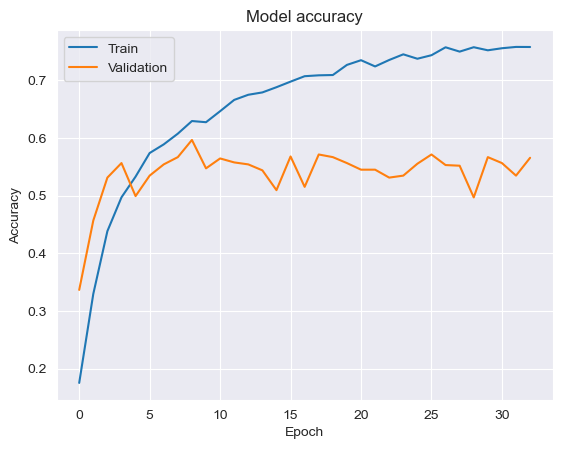

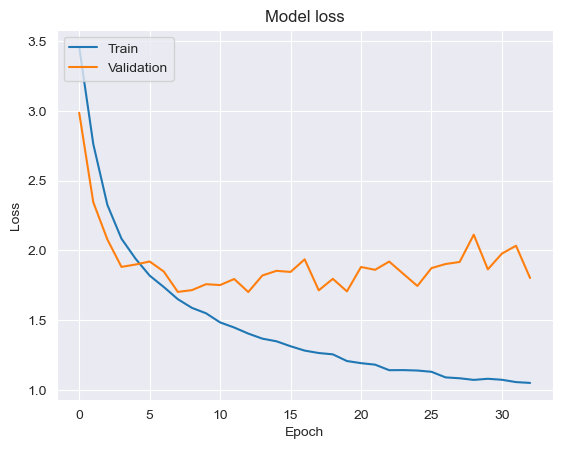

28/28 [==============================] - 0s 1ms/step


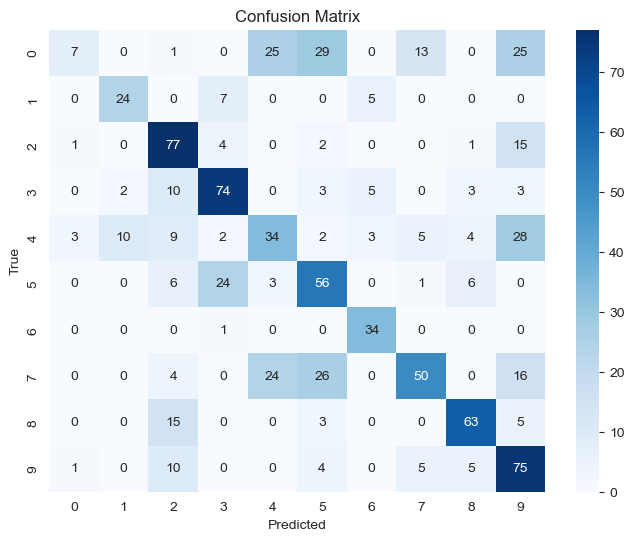

Fold 2


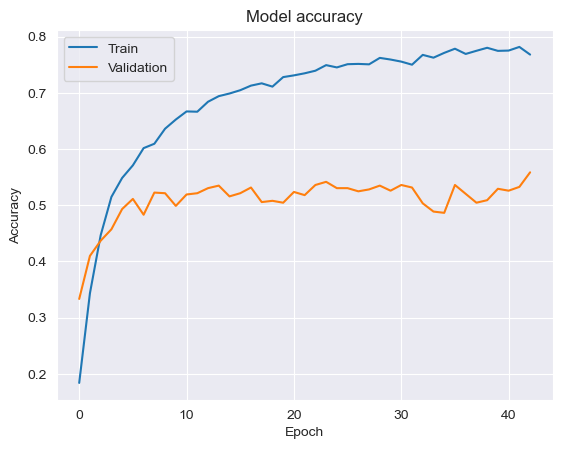

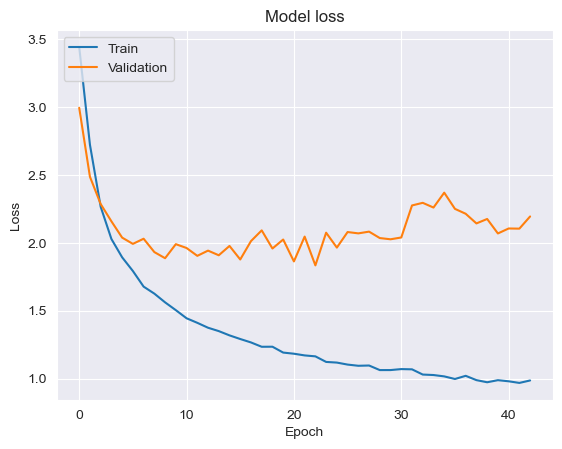

28/28 [==============================] - 0s 3ms/step


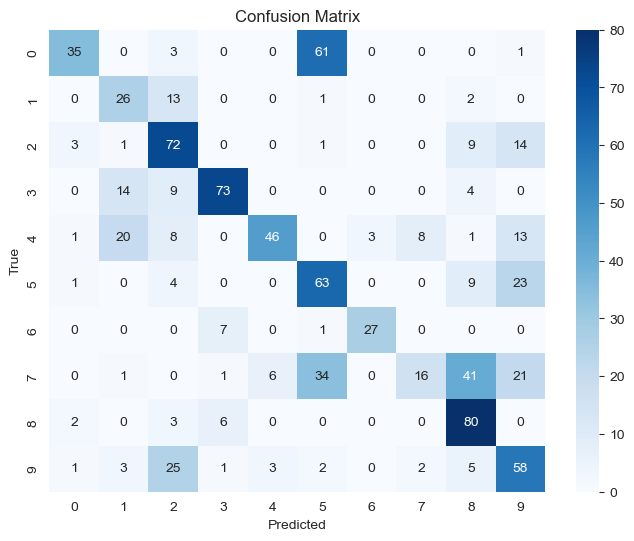

Fold 3


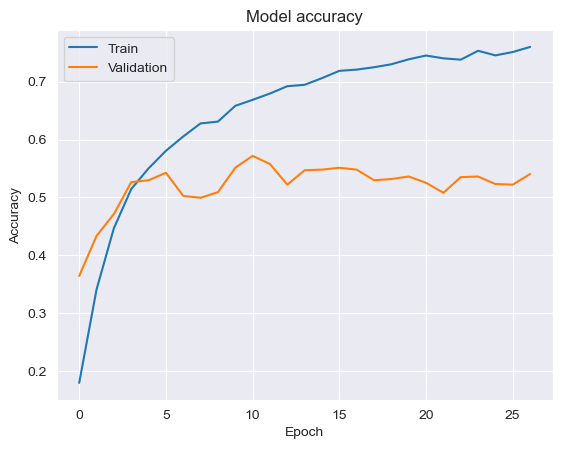

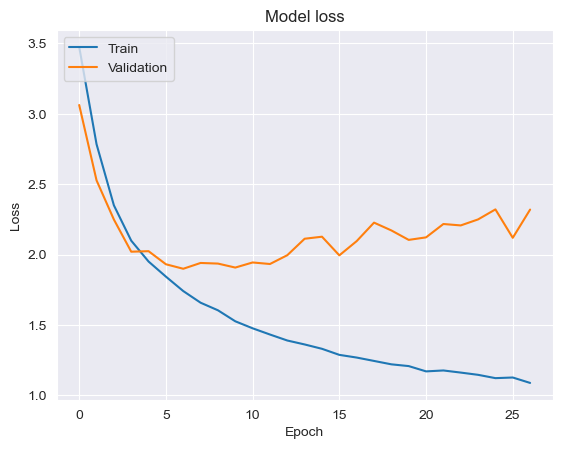

29/29 [==============================] - 0s 3ms/step


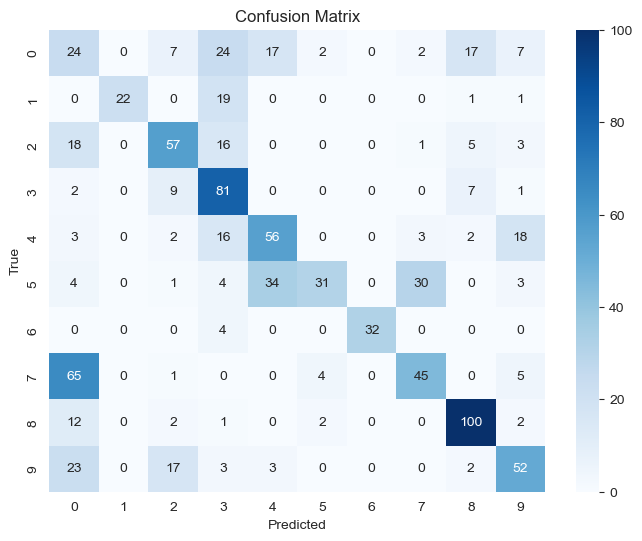

Fold 4


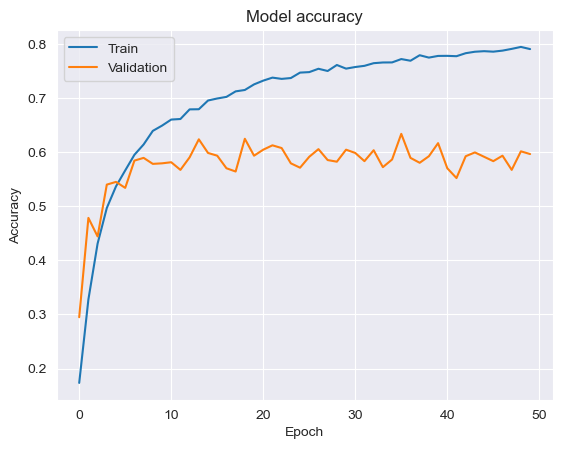

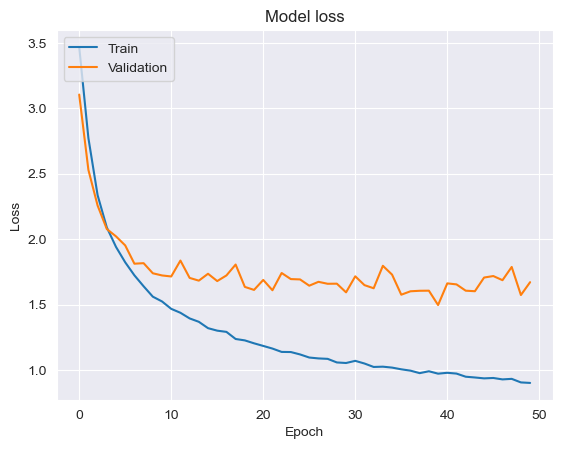

31/31 [==============================] - 0s 2ms/step


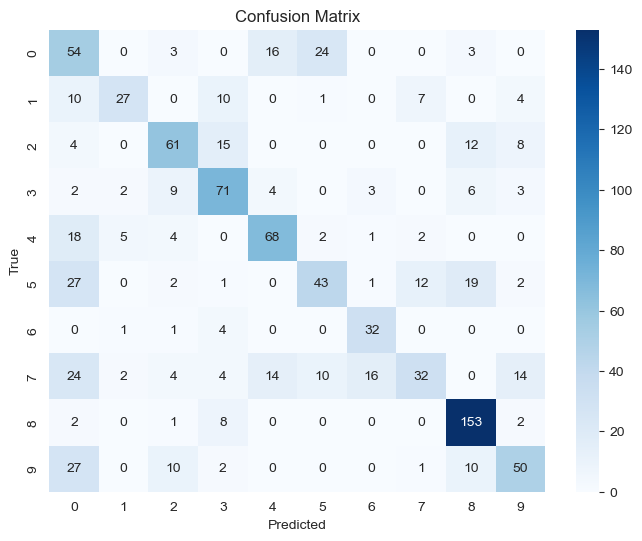

Fold 5


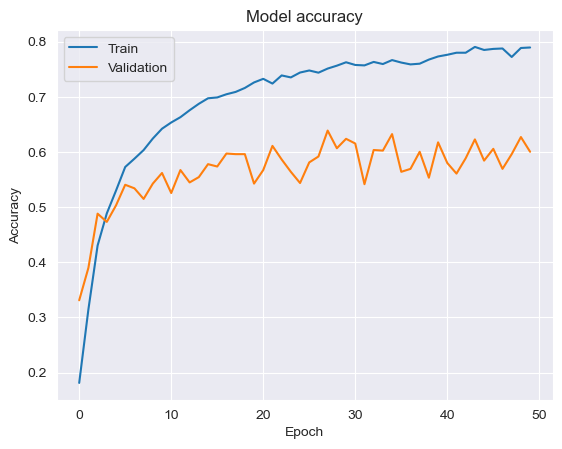

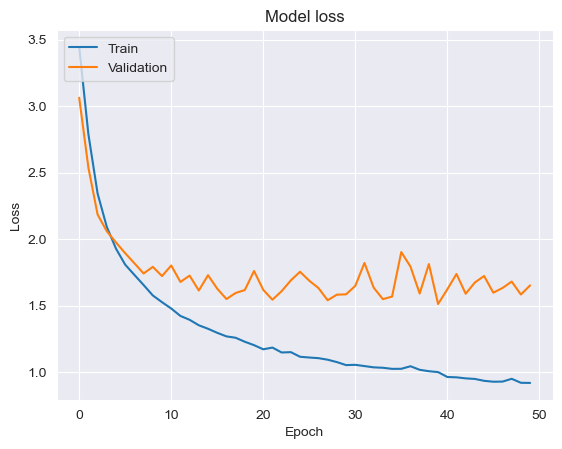

30/30 [==============================] - 0s 3ms/step


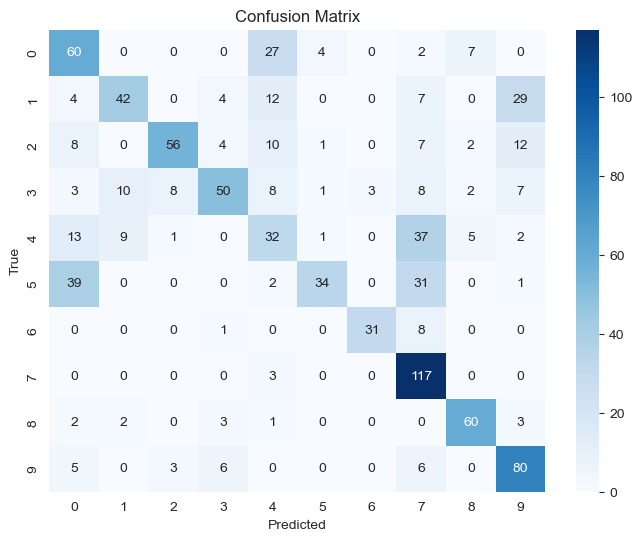

Fold 6


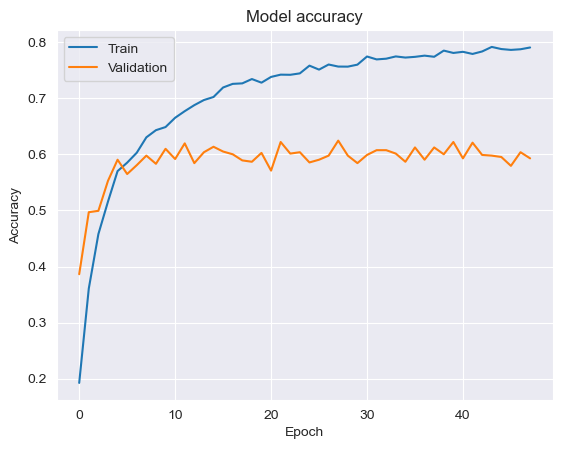

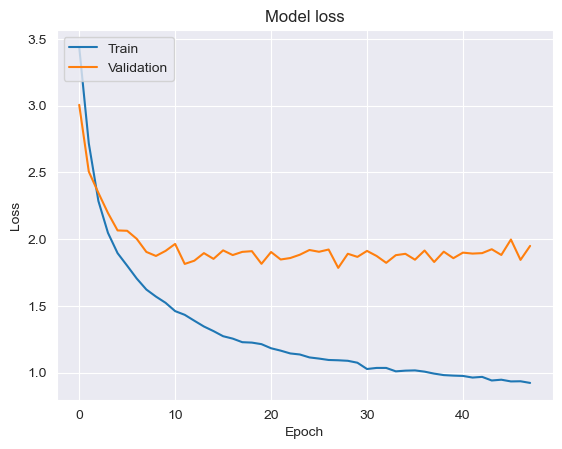

26/26 [==============================] - 0s 3ms/step


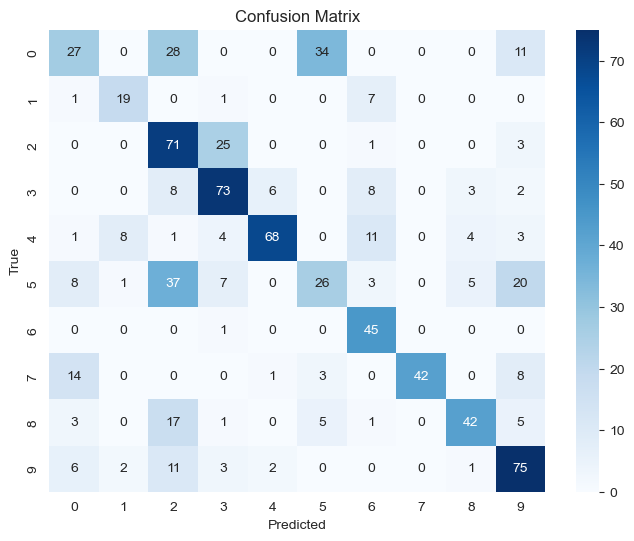

Fold 7


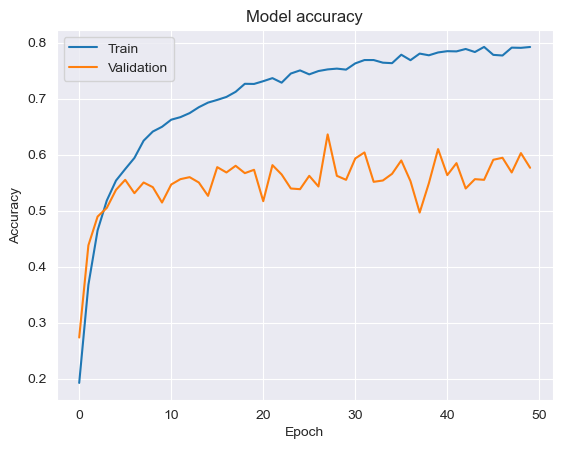

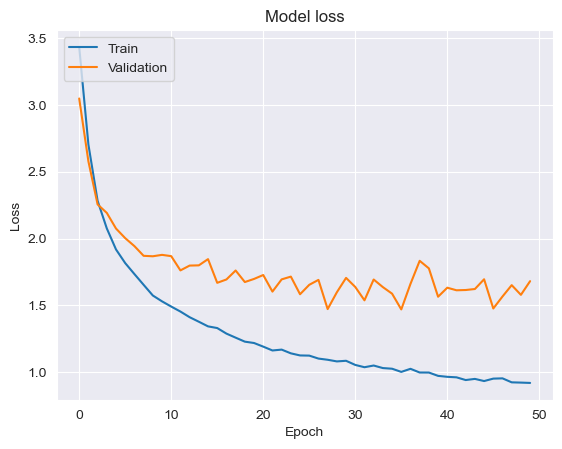

27/27 [==============================] - 0s 2ms/step


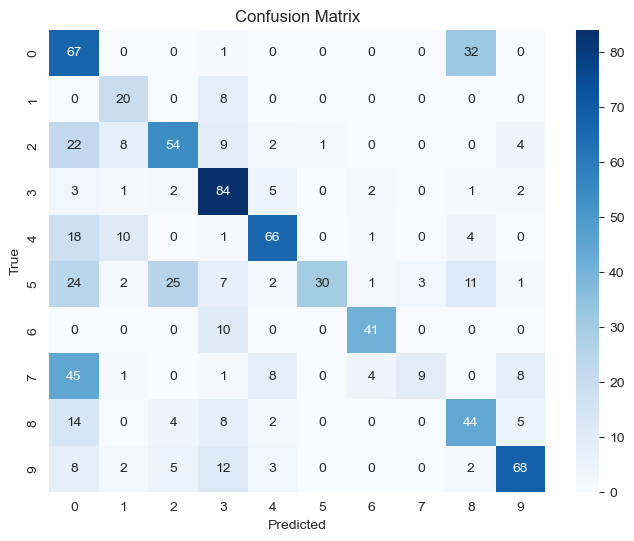

Fold 8


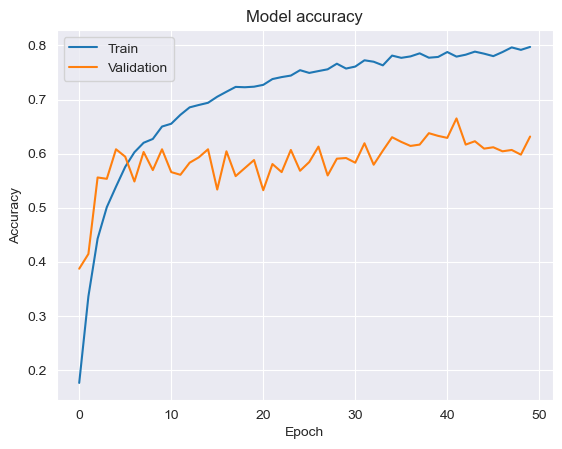

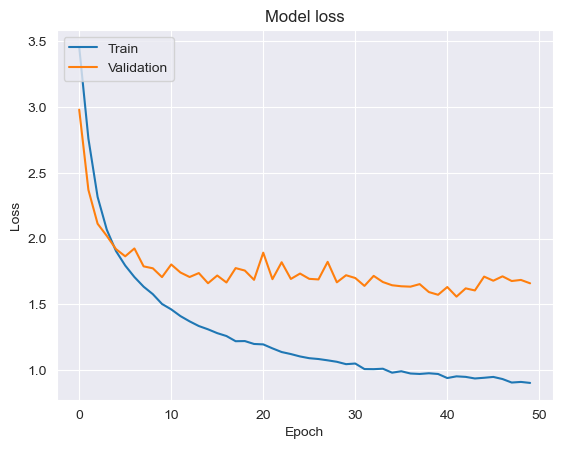

26/26 [==============================] - 0s 2ms/step


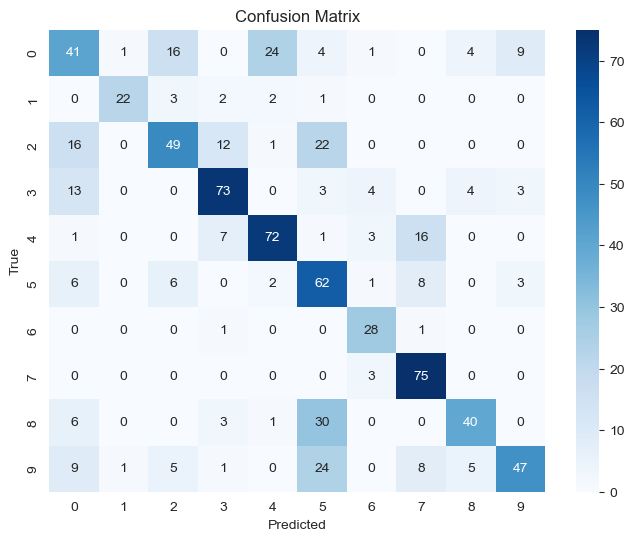

Fold 9


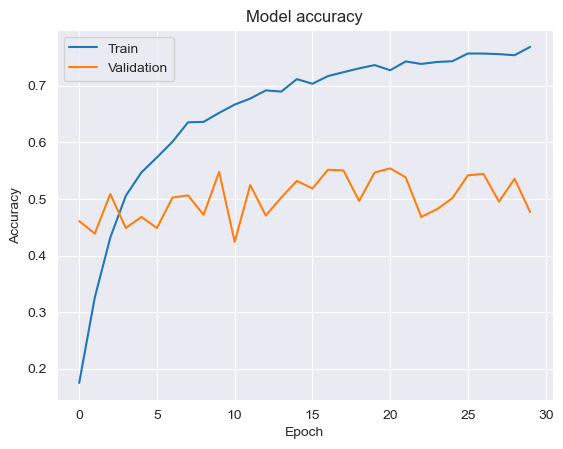

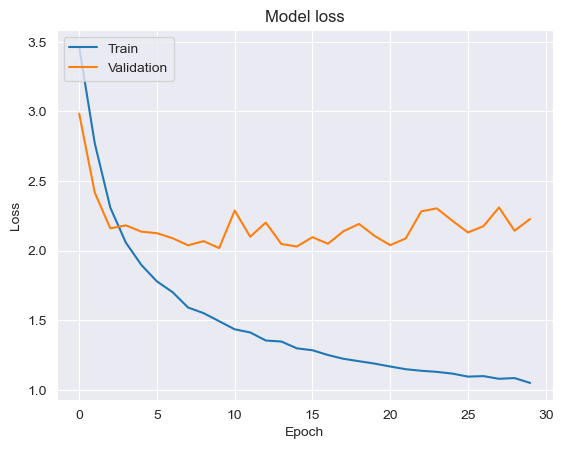

26/26 [==============================] - 0s 2ms/step


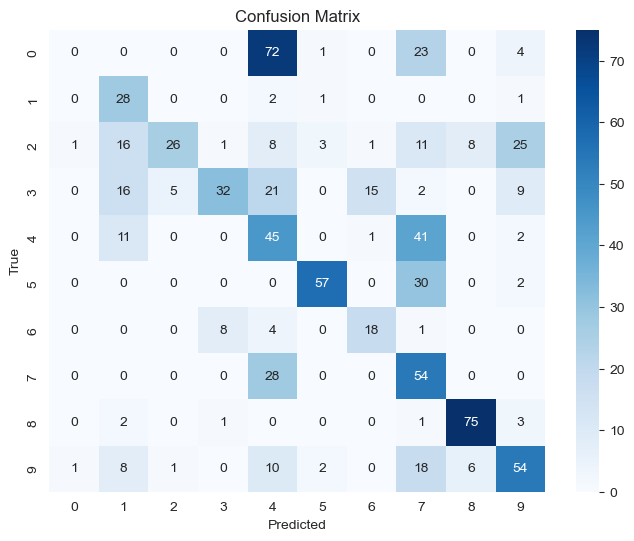

Fold 10


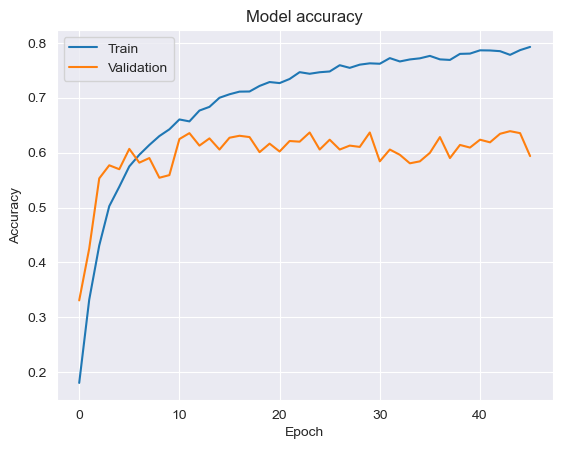

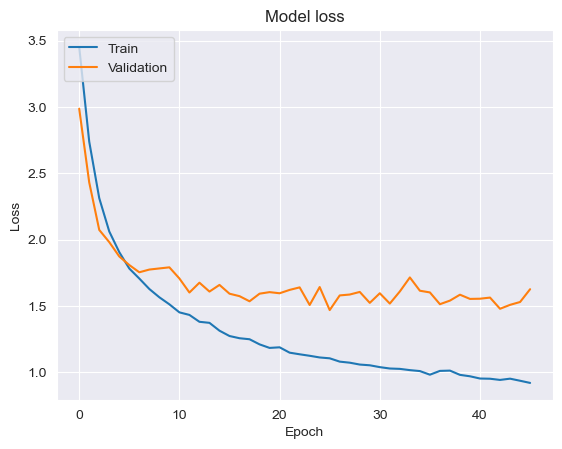

27/27 [==============================] - 0s 1ms/step


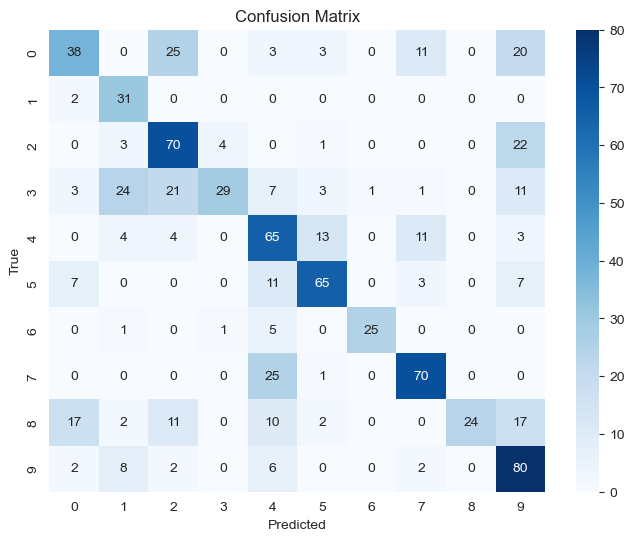


Optimized Average Accuracy for MLP: 0.5734


In [12]:
cv_scores_mlp = []

for fold in range(10):
    print(f"Fold {fold + 1}")
    train_data, train_labels, test_data, test_labels = prepare_datasets(fold)

    model = build_MLP(input_neurons=512,
                      hidden_neurons=512,  # Adjusted based on the recommendation
                      output_neurons=10,
                      learning_rate=0.0005,
                      regulizer=0.001,
                      dropout=0.5)

    history = train_MLP(train_data, train_labels, test_data, test_labels,
                        patience=20,
                        batch_size=128,
                        num_epochs=50)
    plot_learning_curve(history)  # Uncomment if you want to visualize the learning curve

    predictions = model.predict(test_data)
    predicted_labels = np.argmax(predictions, axis=1)
    plot_confusion_matrix(test_labels, predicted_labels, class_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    accuracy = accuracy_score(test_labels, predicted_labels)
    cv_scores_mlp.append(accuracy)

overall_average_accuracy_mlp = np.mean(cv_scores_mlp)
print(f"\nAverage Accuracy for MLP: {overall_average_accuracy_mlp:.4f}")


# CNN

In [15]:
cv_scores_cnn = []
for fold in range(10):
    print(f"Fold {fold + 1}")
    train_data, train_labels, test_data, test_labels = prepare_datasets(fold)

    cnn_model = build_CNN(input_shape=train_data.shape[1:],
                          num_classes=10,
                          learning_rate=0.0001,
                          dropout_rate=0.5)

    history = train_CNN(train_data, train_labels, test_data, test_labels,
                        patience=5,
                        batch_size=32,
                        num_epochs=50)
    #plot_learning_curve(history)  # Uncomment if you want to visualize the learning curve

    predictions_cnn = cnn_model.predict(test_data)
    predicted_labels_cnn = np.argmax(predictions_cnn, axis=1)
    #plot_confusion_matrix(test_labels, predicted_labels, class_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    accuracy = accuracy_score(test_labels, predicted_labels_cnn)
    cv_scores_cnn.append(accuracy)

overall_average_accuracy_cnn = np.mean(cv_scores_cnn)
print(f"\nAccuracy for CNN: {overall_average_accuracy_cnn:.4f}")


Fold 1
28/28 [==============================] - 0s 2ms/step
Fold 2
28/28 [==============================] - 0s 1ms/step
Fold 3
29/29 [==============================] - 0s 3ms/step
Fold 4
31/31 [==============================] - 0s 1ms/step
Fold 5
30/30 [==============================] - 0s 1ms/step
Fold 6
26/26 [==============================] - 0s 1ms/step
Fold 7
27/27 [==============================] - 0s 1ms/step
Fold 8
26/26 [==============================] - 0s 1ms/step
Fold 9
26/26 [==============================] - 0s 943us/step
Fold 10
27/27 [==============================] - 0s 844us/step

Accuracy for CNN: 0.5547
